# Exoplanet Archive Information

Exoplanet Archive Information is the master index of which exoplanets have been "found", either as CONFIRMED, CANDIDATE, FALSE POSITIVE

When an exoplanet gets "found" it is also given a human-friendly name

In [46]:
# Python imports and settings
import numpy  as np
import pandas as pd
import re
from pydash import py_ as _
from src.dataset_koi import koi, koi_columns, koi_column_types

# https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', 8)  # 8 is required for .describe()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Dataset

In [47]:
dataset = pd.DataFrame.join( koi['id'], koi['archive'] ); 
dataset

,kepid,kepoi_name,kepoi_star,kepler_name,koi_disposition
kepoi_name,,,,,
K00752.01,10797460,K00752.01,K00752,Kepler-227 b,CONFIRMED
K00752.02,10797460,K00752.02,K00752,Kepler-227 c,CONFIRMED
K00753.01,10811496,K00753.01,K00753,NaN,CANDIDATE
K00754.01,10848459,K00754.01,K00754,NaN,FALSE POSITIVE
...,...,...,...,...,...
K07986.01,10128825,K07986.01,K07986,NaN,CANDIDATE
K07987.01,10147276,K07987.01,K07987,NaN,FALSE POSITIVE
K07988.01,10155286,K07988.01,K07988,NaN,CANDIDATE
K07989.01,10156110,K07989.01,K07989,NaN,FALSE POSITIVE


In [342]:
# Unused
confirmed_kepoi_star_names = dataset.query('koi_disposition == "CONFIRMED"')['kepoi_star'].tolist()
confirmed_kepoi_systems    = dataset[ dataset['kepoi_star'].isin(confirmed_kepoi_star_names) ]

## Basic Statistics

#### Object Counts

In [68]:
pd.Series({
    "Number of KOIs":                 dataset['kepoi_name'].dropna().unique().size,
    "Number of Solar Systems":        dataset['kepoi_star'].dropna().unique().size,
    "Number of Named Planets":        dataset['kepler_name'].dropna().unique().size,
})

Number of KOIs             9564
Number of Solar Systems    8214
Number of Named Planets    2305
dtype: int64

#### KOI Dispositions - CANDIDATE / CONFIRMED / FALSE POSITIVE

In [80]:
koi_disposition_counts = (
    pd.DataFrame(
        dataset
            .groupby('koi_disposition')
            .size()
            .map(lambda count: {
                "count":      count, 
                "percentage": round(count/dataset.shape[0] * 100, 1)
            })
            .to_dict()
    ).transpose()
)
koi_disposition_counts

,count,percentage
CANDIDATE,2420.0,25.3
CONFIRMED,2303.0,24.1
FALSE POSITIVE,4841.0,50.6


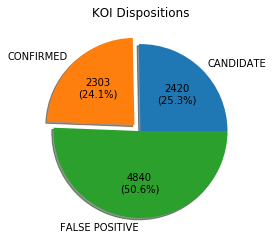

CANDIDATE         2420.0
CONFIRMED         2303.0
FALSE POSITIVE    4841.0
Name: count, dtype: float64

In [266]:
def pie_label(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:d}\n({:.1f}%)".format(absolute, pct)    

plt.pie(
    koi_disposition_counts['count'], 
    labels=koi_disposition_counts.index,     
    explode=(0,0.1,0,), 
    #     autopct='%1.1f%%',
    autopct=lambda pct: pie_label(pct, koi_disposition_counts['count']),    
    shadow=True, 
)
plt.title("KOI Dispositions")
plt.show()

koi_disposition_counts['count']

#### Average Number of KOIs per System

In [255]:
kois_per_system = pd.DataFrame(
    dataset.groupby('koi_disposition', sort=False)
        .apply(lambda group: (
            group.groupby('kepoi_star')
                .size()
                .where(lambda size:  size > 0).dropna()
                .pipe(lambda star: { 
                    "disposition": group.name,
                    "min":  star.min(),
                    "median": round(star.median(),2),                                        
                    "mean": round(star.mean(),2),
                    "max":  star.max(),
                })
        ))
        .tolist(),
)
kois_per_system.set_index('disposition', inplace=True)
kois_per_system

,min,median,mean,max
disposition,,,,
CONFIRMED,1.0,1.0,1.41,7.0
CANDIDATE,1.0,1.0,1.10,4.0
FALSE POSITIVE,1.0,1.0,1.03,5.0


## Question: Are All Named Planets Confirmed

In [131]:
dataset[ dataset['kepler_name'].notnull() ].groupby('koi_disposition').size()

koi_disposition
CANDIDATE         0   
CONFIRMED         2303
FALSE POSITIVE    2   
dtype: int64

Lets have a look at the 2 false positives

In [256]:
dataset[ 
      (dataset['kepler_name'].notnull()) 
    & (dataset['koi_disposition'] == 'FALSE POSITIVE') 
]

,kepid,kepoi_name,kepoi_star,kepler_name,koi_disposition
kepoi_name,,,,,
K00126.01,5897826,K00126.01,K00126,Kepler-469 b,FALSE POSITIVE
K00242.01,3642741,K00242.01,K00242,Kepler-503 b,FALSE POSITIVE


Google Fu has a little more information on these named False Positives

Kepler-469 b: https://twitter.com/exohugh/status/1169262460504875008 
<blockquote>
Twitter: Hugh Osborn @exohugh - Sep 4, 2019
    
He [Alexandre Santerne] also kills Kepler-469b which is a validated Kepler planet yet is clearly a binary fold in the wrong period. #PlatoESP
</blockquote>

Kepler-503 b: https://arxiv.org/abs/1805.08820
<blockquote>
arxiv: Kepler-503b: An Object at the Hydrogen Burning Mass Limit Orbiting a Subgiant Star
</blockquote>



